In [39]:
%matplotlib inline
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.stats import norm
import matplotlib.pyplot as plt
from astropy.table import Table
import abc

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

In [225]:
t_nn = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod_18oct2021/neighbors.fits')
t_target = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod_18oct2021/GalaxyFilteringTask/star_catalog.fits')
t_ref = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod_18oct2021/ProductionInputEcdmHandler/star_reference_sample_dir.dir/phot.fits', hdu=1)

config = dict()
with open('/home/aalvarez/Work/Data/SC8/PHZ_Prod_18oct2021/data/nnpz_star_sed_07Jun2021-094516.conf', 'r') as fd:
    exec(fd.read(), config)
   
target_photo = np.asarray([(t_target[0][f], t_target[0][e]) for (f, e) in config['target_catalog_filters']])
ref_photo = np.asarray([t_ref[t_nn[0]['NEIGHBOR_INDEX'][0]][f] for f in config['reference_sample_phot_filters']])
ref_photo = np.column_stack([ref_photo, np.zeros_like(ref_photo)])

assert target_photo.shape == ref_photo.shape, (target_photo.shape, ref_photo.shape)

In [226]:
ref_photo[:,0]

array([0.06105111, 0.43683136, 1.0020354 , 1.4098276 , 1.6121303 ,
       1.2250347 , 1.8081652 , 1.8983316 , 1.9702266 ], dtype=float32)

In [227]:
target_photo[:,0]

array([0.28606794, 1.25927929, 2.99065662, 4.52617146, 5.61709861,
       3.89831762, 6.53332376, 6.34905922, 6.5748412 ])

In [247]:
t_nn['NEIGHBOR_SCALING'][0]

array([3.4576743, 4.0636053, 3.354015 , 3.9699976, 3.6454432, 4.1841173,
       4.2458177, 4.050698 , 3.4260645, 4.1174536, 4.017645 , 3.3707922,
       4.0982428, 3.3333573, 4.204324 , 4.0278754, 3.3904085, 4.1567154,
       4.0611973, 4.118459 , 4.19831  , 4.021677 , 3.4540596, 3.4060113,
       3.3427324, 3.9920332, 4.1659794, 4.135689 , 3.8232434, 4.0722957],
      dtype=float32)

In [229]:
class Prior(abc.ABC):
    @abc.abstractmethod
    def __call__(self, a):
        pass
    
    @abc.abstractmethod
    def derivative(self):
        pass
    
    @abc.abstractmethod
    def range(self):
        pass

class Uniform(Prior):
    def __call__(self, a):
        return np.ones_like(a)
    
    def derivative(self):
        return None
    
    def range(self):
        return -np.inf, np.inf

class Delta(Prior):
    def __init__(self, v):
        self._v = v
        
    def __call__(self, a):
        a = np.asarray(a)
        p = np.zeros_like(a)
        p[a==self._v] = 1.
        return p
    
    def derivative(self):
        def d(a):
            a = np.asarray(a)
            v = np.zeros_like(a)
            v[a==self._v] = np.inf
            return v
        return d
    
    def range(self):
        return self._v, self._v

class Step(Prior):
    def __init__(self, mn, mx):
        self._min, self._max = mn, mx
        
    def __call__(self, a):
        a = np.asarray(a)
        p = np.zeros_like(a)
        p[(a>=self._min) & (a<=self._max)] = 1.
        return p
    
    def derivative(self):
        def d(a):
            a = np.asarray(a)
            v = np.zeros_like(a)
            v[(a==self._min) | (a ==self._max)] = np.inf
            return v
        return d
    
    def range(self):
        return self._min, self._max

class FromData(Prior):
    def __init__(self, x, y):
        self._f = UnivariateSpline(x, y, s=0, ext='zeros')
        rx = x[y > 0]
        self._min, self._max = rx.min(), rx.max()
        
    def __call__(self, a):
        return self._f(a)
    
    def derivative(self):
        return self._f.derivative()
    
    def range(self):
        return self._min, self._max

In [230]:
x1 = np.linspace(0, 10, 100)
priors = dict(
    uniform = Uniform(),
    delta2 = Delta(2.),
    step = Step(0.5, 3.),
    from_data = FromData(x1, norm(5).pdf(x1))
)

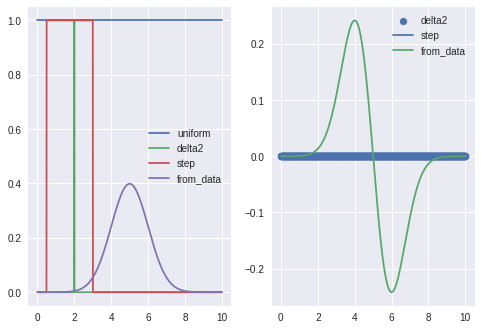

In [231]:
x = np.linspace(0., 10., 1001)

fig, axes = plt.subplots(ncols=2)
for k, p in priors.items():
    axes[0].plot(x, p(x), label=k)
    d = p.derivative()
    if d:
        if k.startswith('delta'):
            axes[1].scatter(x, d(x), label=k)
        else:
            axes[1].plot(x, d(x), label=k)
        
axes[0].legend()
axes[1].legend()

plt.show()

In [232]:
class Chi2:
    def __init__(self, ref, target):
        self._ref, self._target = ref, target
        
    def guess(self):
        nom = self._ref[...,0] * self._target[...,0] / self._target[...,1] ** 2
        den = self._ref[...,0] ** 2 / self._target[...,1] ** 2
        return np.sum(nom) / np.sum(den)
        
    def __call__(self, a):
        a = np.asarray(a)
        nom = (self._ref[...,0] * a[..., np.newaxis] - self._target[...,0]) ** 2
        den = (self._ref[...,1] * a[..., np.newaxis]) ** 2 + self._target[...,1] ** 2
        return np.sum(nom / den, axis=-1)
    
    def derivative(self):
        def d(a):
            a = np.asarray(a)[...,np.newaxis]
            rval = self._ref[...,0]
            tval = self._target[...,0]
            rerr = self._ref[...,1]
            terr = self._target[...,1]
            nom = 2 * (a * rval - tval) * (rerr * rerr * a * tval + rval * terr * terr)
            den = rerr * rerr * a * a + terr * terr
            den *= den
            return np.sum(nom/ den, axis=-1)
        return d

In [233]:
chi2 = Chi2(ref_photo, target_photo)
a_guess = chi2.guess()

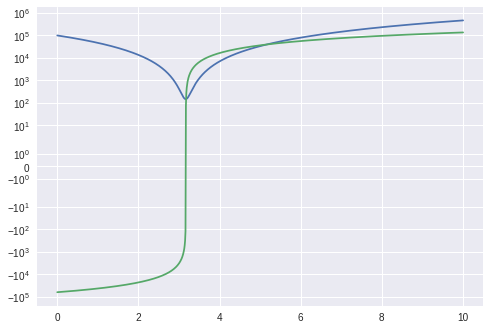

In [234]:
plt.figure()
plt.plot(x, chi2(x))
plt.plot(x, chi2.derivative()(x))
plt.yscale('symlog')
plt.show()

In [235]:
# TO BE MINIMIZED
class Chi2Prior:
    def __init__(self, chi2, prior):
        self._chi2, self._prior = chi2, prior
        
    def __call__(self, a):
        return self._chi2(a) / 2 - np.log(self._prior(a))
    
    @property
    def range(self):
        return self._prior.range()
    
    def derivative(self):
        pd = self._prior.derivative()
        chi2d = self._chi2.derivative()
        if pd is None:
            return chi2d
        return lambda a: chi2d(a) / 2 - 1 / self._prior(a) * pd(a)

In [236]:
chi2_prior = {k: Chi2Prior(chi2, p) for k, p in priors.items()}

/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


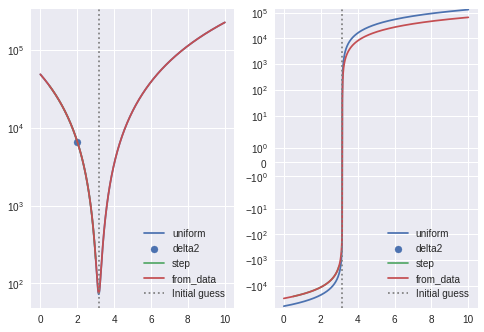

In [237]:
fig, axes = plt.subplots(ncols=2, sharex=True)
for k, cp in chi2_prior.items():
    if k.startswith('delta'):
        axes[0].scatter(x, cp(x), label=k)
    else:
        axes[0].plot(x, cp(x), label=k)
        
    d = cp.derivative()
    if d:
        if k.startswith('delta'):
            axes[1].scatter(x, d(x), label=k)
        else:
            axes[1].plot(x, d(x), label=k)
        
axes[0].axvline(a_guess, label='Initial guess', linestyle=':', color='gray')
axes[0].legend()
axes[0].set_yscale('log')
axes[1].axvline(a_guess, label='Initial guess', linestyle=':', color='gray')
axes[1].set_yscale('symlog')
axes[1].legend()
plt.show()

In [238]:
def secant(f, guess, mn, mx, maxiter, atol):
    eps = 1e-4
    x0 = guess * (1-eps)
    x1 = guess * (1+eps)
    for i in range(maxiter):
        dx = f(x1) * (x1 - x0) / (f(x1) - f(x0))
        if abs(dx) < atol:
            break
        guess = x1 - dx
        if guess >= mx or guess <= mn:
            break
        x0, x1 = x1, guess
    return guess

In [239]:
def resolve_scale(chi2p, guess, maxiter, atol):
    d = chi2p.derivative()
    xmin, xmax = chi2p.range
    if np.isclose(xmin, xmax):
        return xmin
    guess = np.clip(guess, xmin+2e-4, xmax-2e-4)
    return secant(d, guess, xmin, xmax, maxiter, atol)

In [240]:
a_guess

3.166232911584521

In [241]:
resolve_scale(chi2_prior['uniform'], a_guess, 100, 1e-8)

3.166232864086747

In [242]:
chi2_prior['uniform'](0.8362419401272728), chi2_prior['uniform'](0.837),  chi2_prior['uniform'](0.835)

(26352.01350505848, 26334.916234663982, 26380.036226831802)

In [243]:
resolve_scale(chi2_prior['delta2'], a_guess, 100, 1e-8)

2.0

In [244]:
chi2_prior['delta2'].derivative()(2.0)

-inf

In [245]:
resolve_scale(chi2_prior['from_data'], a_guess, 100, 1e-8)

3.1664222584284563

In [246]:
resolve_scale(chi2_prior['step'], a_guess, 100, 1e-8)

/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/miniconda3/envs/phz/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


nan